# MC Estimation for Blackjack

The code is modified from https://github.com/Twice22/HandsOnRL/blob/master/chapter3/MonteCarloEstimations.ipynb

Key points to change: 
1. Using v1 env instead of v0 env
2. Add winning evaluation 

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('text', usetex=True)

import gym
import numpy as np
from collections import defaultdict
from utils import plot_state_values
from utils import plot_policy


env = gym.make('Blackjack-v1', natural=False, sab=False)

### Monte-Carlo for estimating V^π
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

In [2]:
def generate_episode_deterministic(env):
    state, _ = env.reset()  
    episode = []
    while True:
        action = int(state[0] <= 18)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:  
            break
    return episode

def MCV(env, generate_episode, gamma, episodes):
    V, returns = defaultdict(float), defaultdict(list)
    
    for _ in range(episodes):
        trajectory = generate_episode(env)
        G = 0
        visited_states = set()
        
        for i in reversed(range(len(trajectory))):
            state, action, reward = trajectory[i]
            G = gamma * G + reward
            
            if state not in visited_states:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
                visited_states.add(state)
                
    return V

### Monte-Carlo for estimating Q^π
def generate_episode_stochastic(env):
    state, _ = env.reset()  
    episode = []
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice([0, 1], p=probs)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:  
            break
    return episode

def MCQ(env, generate_episode, gamma, episodes):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    
    for _ in range(episodes):
        trajectory = generate_episode(env)
        G = 0
        visited_pairs = set()
        
        for i in reversed(range(len(trajectory))):
            state, action, reward = trajectory[i]
            G = gamma * G + reward
            
            if (state, action) not in visited_pairs:
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])
                visited_pairs.add((state, action))

    pi = {state: np.argmax(q_values) for state, q_values in Q.items()}
    return Q, pi

def QtoV(Q):
    V = {}
    for state, values in Q.items():
        if state[0] < 18:
            V[state] = np.dot(values, [0.2, 0.8])
        else:
            V[state] = np.dot(values, [0.8, 0.2])
    return V


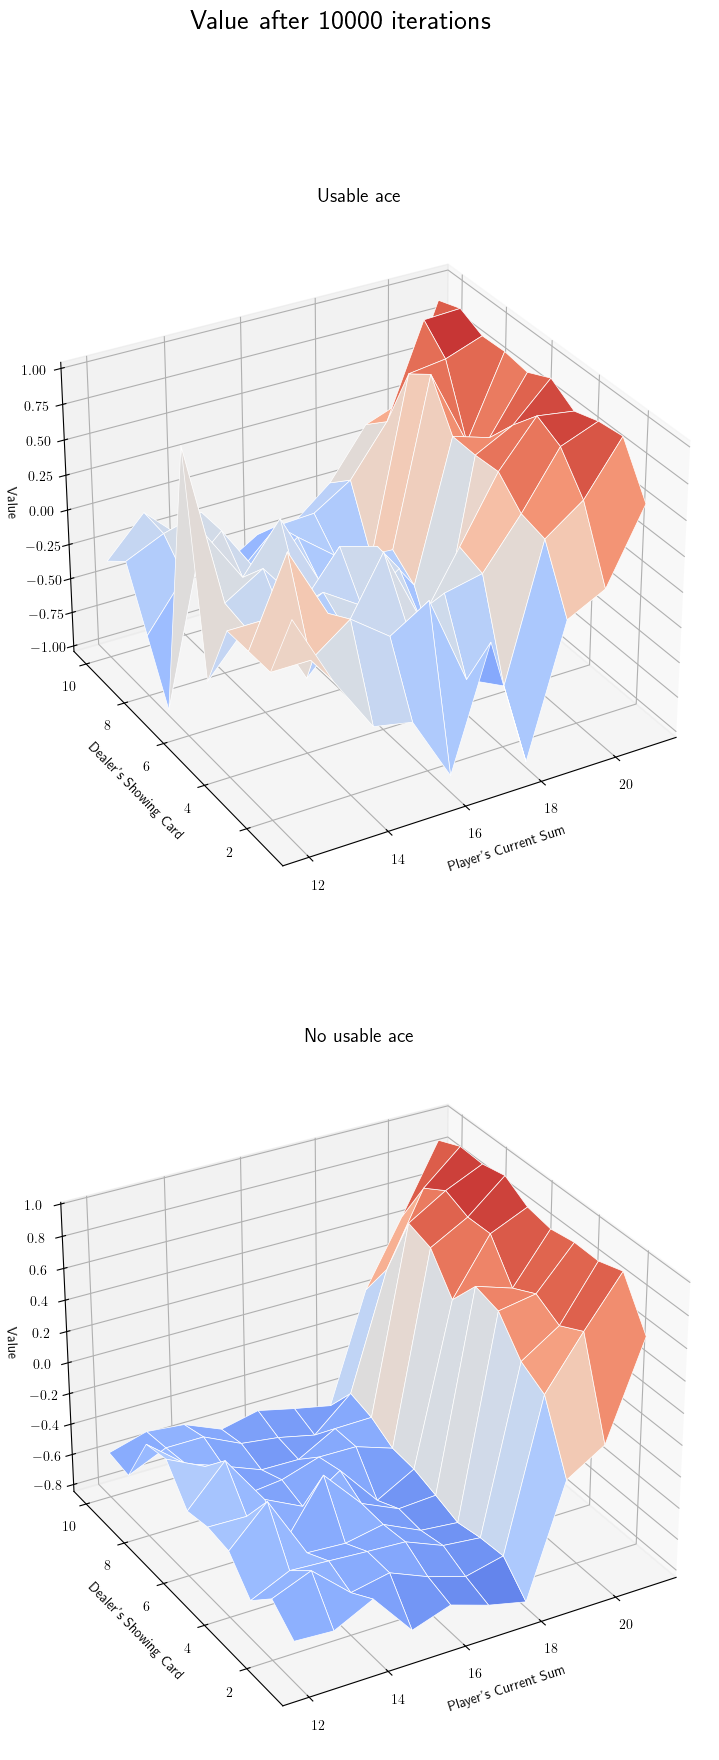

In [3]:
n_episodes = 10000
V = MCV(env, generate_episode_deterministic, 1.0, n_episodes)
plot_state_values(V, n_episodes)

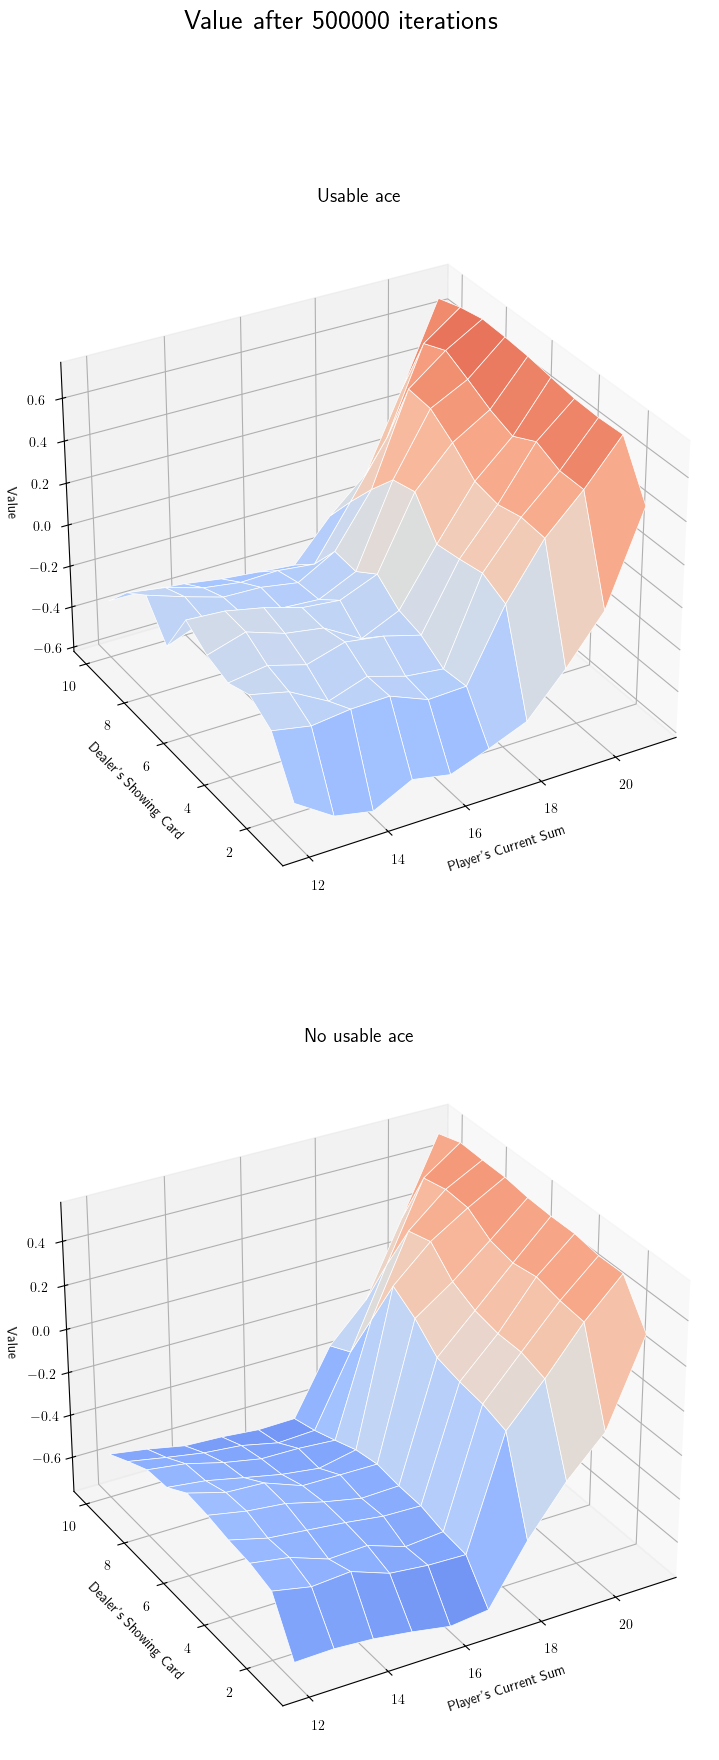

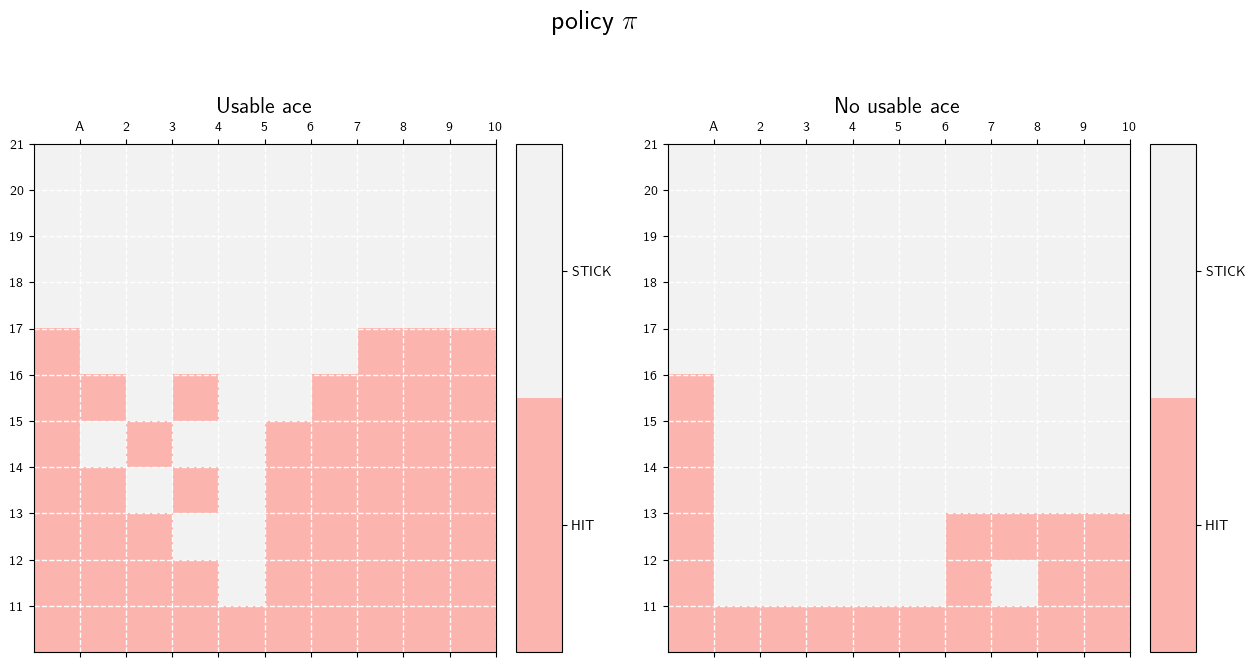

In [4]:
n_episodes = 500000
Q, pi = MCQ(env, generate_episode_stochastic, 1.0, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)
plot_policy(pi, r"policy $\pi$")

## Evaluation

Now, we need to evaluate the win rate of our policy

Simple set-up :
win: +1, draw: 0, lose: -1

In [7]:
def evaluate_policy(env, policy, num_episodes=100, seed=None):
    """
    Evaluate the policy in the environment.
    参数：
        env: Gym/Gymnasium
        policy: policy dict, {player_sum, dealer_card, usable_ace: action}
        num_episodes: number of episodes to evaluate
        seed: 
    Return：
        win_rate
        lose_rate
        draw_rate
    """
    results = {
        'win': 0,
        'lose': 0,
        'draw': 0,
        'unknown': 0
    }
    
    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed+episode if seed else None)
        terminated = False
        truncated = False
        
        while not (terminated or truncated):
            if state in policy:
                action = policy[state]
            else:
                action = 1 if state[0] < 18 else 0
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
        
        if reward == 1:
            results['win'] += 1
        elif reward == -1:
            results['lose'] += 1
        elif reward == 0:
            results['draw'] += 1
        else:
            results['unknown'] += 1
    
    total = sum(results.values())
    return {
        'win_rate': results['win'] / total,
        'lose_rate': results['lose'] / total,
        'draw_rate': results['draw'] / total,
        'raw_counts': results
    }


env = gym.make('Blackjack-v1', natural=False, sab=False)
results = evaluate_policy(env, pi, num_episodes=1000, seed=42)
print(f"Evaluation results:")
print(f"winning times: {results['raw_counts']['win']} win rate: {results['win_rate']*100:.1f}%")
print(f"losing times: {results['raw_counts']['lose']} lose rate: {results['lose_rate']*100:.1f}%")
print(f"draw times: {results['raw_counts']['draw']} draw rate: {results['draw_rate']*100:.1f}%")

Evaluation results:
winning times: 442 win rate: 44.2%
losing times: 489 lose rate: 48.9%
draw times: 69 draw rate: 6.9%
